# Multiple Objective Routing Path Optimization

## Group Members
- **s5631590** - Kevin Ocansay Djabaku  
- **s5724569** - Joachim Ayodeji Braimah  
- **s5612692** - Yeboah Danquah Adwoa  
- **s5725839** - Adebisi Ademola Victor  
- **s5718601** - Worlu Edward Chimzindu

![national_park.png](./national_park.png)

# Introduction

Efficient routing in wireless sensor networks is essential for reliable environmental monitoring. This study addresses the optimization of data packet routing paths for sensors deployed in New Forest National Park, aiming to maximize transmission rates and minimize latency. Given the limited communication range of sensors, data must be relayed through intermediary nodes to reach base stations located at Beaulieu and Lyndhurst. We employed two algorithms to solve this multi-constraint problem: a Genetic Algorithm with some inspiration from Dijkstra's algorithm and an enhanced Ant Colony Optimization (ACO) algorithm. The Genetic Algorithm explores a wide solution space using evolutionary principles, while the idea we combined with it from Dijkstra's efficiently identifies optimal paths within generated neighbors. Conversely, the ACO algorithm utilizes pheromone trails for probabilistic route determination, incorporating modifications for random neighbor selection and conditional pheromone updates to balance exploration and exploitation. Our evaluation metrics focus on end-to-end data transmission rate, defined as the minimum transmission rate across all links in a path, and end-to-end latency as the cumulative delay of all traversed links. But we did not stop there. To get more from our algorithm we expanded our cost function and explore average change in transmission (margin change) and average transmission which was really effective for our Modified Genetic Algorithm.

# Results and Overview
Experimental results indicate that both algorithms effectively optimize routing paths, with the Djisktra + Genetic Algorithm variant achieving higher transmission rates and lower latency compared to our Ant Colony Algorithm. Another fator to look at is the computational complexity. For genetic algorithm, as the population size increased so did our total run time.

| Population size         | Time duration                    |
|-------------------------|----------------------------------|
| 1000                    | 17mins 42secs                    |
| 10,0000                 | 132mins 36sec                    |

<br>

For Ant colony we recorded some runtime as 


<center style="text-align: center;">

| (Ant size ,   Iteration)                        |         Time duration                    |
|-------------------------------------------------|------------------------------------------|
| 50                       50                     | 13mins                                   |
| 500                      1                      | 58 mins                                  |
| 500                      50                     | 140 mins                                 |

</center>

<br>

The varying time could be due to various reasons. However the important thing was the longer both algorithms took the better the routes were.

<br>

# Problem Definition

The primary objective is to identify optimal routing paths from each of the 150 nodes in our park to any of the two base stations (BS1 located at Beaulieu or BS2 at Lyndhurst) within a wireless sensor network. This optimization seeks to balance two critical metrics:

- **End to End Transmission Rate:** Maximizing the data throughput across the network. Let us use an example of the routing path.
Node-5 -> Node-2 -> Node-1 -> BS-2. To illustrate how to calculate the end-to-end data transmission rate. There are three links “Node-5 -> Node-2” with a transmission rate 1Mbs, “Node-2 -> Node-1” with a transmission rate of 4 Mbps, and “Node-1 ->BS-2” with a transmission
rate of 2 Mbps. The end-to-end data transmission rate will be
Min{1 Mbps, 4 Mbps, 2 Mbps} = 1 Mbps. (Department of Computing & Informatics, 2024, p. 2)

<br>

- **Latency:** Minimizing the total delay in data transmission to ensure timely delivery. Using the same example, the delay imposed by each link is 30 milliseconds (ms). There are three links “Node-5 -> Node-2”, “Node-2 -> Node-1”, and
“Node-1 -> BS-2”, so the end-to-end latency consists of three links, and the end-to-end latency will be 3 x 30 = 90 ms.


<br>

 - **Distance-Based Transmission:** The transmission rate between any two nodes is determined by their pairwise distance. The following thresholds define the transmission rate \( t \):

<br>
    
  
<center style="text-align: center;">

| Distance Range (meters) | Transmission Rate \( t \) (Mbps) |
|-------------------------|----------------------------------|
| 3000 >                  | 0                                |
| 2500 – 3000             | 1                                |
| 2000 – 2500             | 2                                |
| 1500 – 2000             | 3                                |
| 1000 – 1500             | 4                                |
| 1000 – 500              | 5                                |
| 500 <                   | 7                                |

</center>

  <br>

  - **Connectivity:** A transmission rate of \( t = 0 \) indicates no direct connection between the nodes due to excessive distance.
  - The Base station coordinates was manually added to our sub_data.csv file.

<br>

#### **Objective**

Our main goal is to pick the best route that balances the cost of increasing end to end transmission while reducing latency.

In [89]:
!pip install pandas numpy matplotlib scipy seaborn pillow

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import random
import seaborn as sns

In [91]:
# We added nodes 151 and 152 to the data file to represent our base stations as stated in the problem brief
# Make sure you have the data file in the same directory as this script
nodes_df = pd.read_csv('sub_data_file.csv', header=None, names=['Node No.', 'x-coordinate', 'y-coordinate'])

print(nodes_df.head())

   Node No.  x-coordinate  y-coordinate
0         1        4873.6        4886.7
1         2       -3295.7       -4330.5
2         3       -2407.1        4397.4
3         4       -1027.0       -4828.9
4         5       -4260.1        1838.4


### **Data Representation**

We used two basic data structures to represent our nodes distributed around the park: a **distance matrix** and a **transmission rate matrix**. The **distance matrix** captures the pairwise distances between nodes using their spatial coordinates, making transmission rates easier to calculate.


In [92]:
def calculate_distance(x1, y1, x2, y2):
    """Calculates the Euclidean distance between two points."""
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Create a distance matrix (NxN where N is the number of nodes)
node_count = len(nodes_df)
distance_matrix = np.zeros((node_count, node_count))

# Compute distances between every pair of nodes
for i in range(node_count):
    for j in range(i+1, node_count):
        node_i = nodes_df.iloc[i]
        node_j = nodes_df.iloc[j]

        # Calculate the Euclidean distance
        distance = calculate_distance(
            node_i['x-coordinate'], node_i['y-coordinate'],
            node_j['x-coordinate'], node_j['y-coordinate']
        )

        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

# Convert the distance matrix to a DataFrame for readability
distance_df = pd.DataFrame(
    distance_matrix,
    index=nodes_df['Node No.'],
    columns=nodes_df['Node No.']
)

print(distance_df.head())

Node No.           1             2            3             4            5    \
Node No.                                                                       
1             0.000000  12316.421490  7297.123199  11367.056071  9628.946390   
2         12316.421490      0.000000  8773.018202   2322.800519  6243.828519   
3          7297.123199   8773.018202     0.000000   9328.948906  3159.444571   
4         11367.056071   2322.800519  9328.948906      0.000000  7409.846483   
5          9628.946390   6243.828519  3159.444571   7409.846483     0.000000   

Node No.          6            7             8            9            10   \
Node No.                                                                     
1         3660.094705  7409.188967   1034.795366  5920.064695  5164.886021   
2         8818.416938  5212.803935  11529.600303  8637.228253  7171.255635   
3         4525.478274  4306.201414   7253.558228  1485.881652  4780.305707   
4         8185.204927  5165.862710  10470.577664 

In [93]:
def get_transmission_rate(distance):
    """Calculate the transmission_rate per the distance range"""
    if distance >= 3000:
        return 0  # No connection
    elif distance > 2500:
        return 1
    elif distance > 2000:
        return 2
    elif distance > 1500:
        return 3
    elif distance > 1000:
        return 4
    elif distance > 500:
        return 5
    else:
        return 7


# Create transmission rate matrices
transmission_rate_matrix = np.zeros((node_count, node_count))

for i in range(node_count):
    for j in range(i+1, node_count):
        distance = distance_matrix[i, j]
        if distance <= 3000:  # Only consider nodes within communication range
            transmission_rate = get_transmission_rate(distance)
            transmission_rate_matrix[i, j] = transmission_rate
            transmission_rate_matrix[j, i] = transmission_rate

# Convert to DataFrame for better readability
transmission_rate_df = pd.DataFrame(transmission_rate_matrix, index=nodes_df['Node No.'], columns=nodes_df['Node No.'])

## Methodology

This section shines light on the systematic approach employed to optimize routing paths that cuts accross for both Algorithms.
We start by formulating our multi-objective cost function, then selection and evaluation of transmission metrics, the application of optimization algorithms, and the validation of optimized routes through simulation.



## 1. Cost Function 
A cost function allows us to **evaluate routes** in a network based on multiple criteria (e.g., **latency** and **transmission rate**) and select the optimal route. It can be seen in other parts of teh report as fitness function.

### Key Objectives:
- **Minimize Latency**: Reduce the time taken for data to travel through the network.
- **Maximize Transmission Rate**: Choose the route with the highest minimum transmission rate within its route.
- **Explore Optional Metrics**: Aside min-max end to end transmission we will explore other metrics that can help us select the best routes.
- **Balance Tradeoffs**: Use weights to reflect the relative importance of these metrics.

<br>


## 2. Components of the Cost Function
1. **Latency (L)**: Dependent on the number of hops (n) in the route.
   - `L = 30 * n` (where each hop adds 30 ms).

2. **Transmission Rate (T)**: Dependent on the rates of each hop in the route.[ 0-7]
   - Aside min-max end to end transmission rate `T`, we explored total, average, and margin change of end to end transmission rate.

### General Cost Function:
The general form: C(n, t_1, t_2, ..., t_n) = weights * T - weights * L
Where:
- `T`: Metric for end-to-end transmission rate (e.g., average, sum, or min-max).
- `L`: Total latency, calculated as `30 * n`.

---

## 3. Exploring other transmission metrics

### A. Using Average Transmission Rate
- **Why Average?**  
  When we have routes with the same min-max end to end transmission rate and the same latency we will need the average transmisison rate to help differentiate which one is a better route.


  - Formula:
    ```
    T = (1/n) * sum(t_i for i in range(1, n+1))
    ```
- **Impact**:
  - Encourages routes with **consistent transmission rates**.
  - Penalizes routes with individual slow nodes without dismissing them entirely.
  - Works well when the network has many nodes, as it reflects the overall quality of the route.
  -
---

<br>


### B. Marginal Impact of Each Hop
- **Why Marginal Impact?**  
  Marginal analysis allows us to evaluate how each hop contributes to the tradeoff between transmission and latency. Does the route get better over time, or does the transmission rate get worse.
  - Formula:
    ```
    Marginal Impact = (delta * ΔT) - (beta * ΔL)
    ```
    - `ΔT`: Change in transmission rate between consecutive hops.
    - `ΔL`: Fixed latency per hop (e.g., 30 ms).

- **Impact**:  
  - Highlights routes that show a steady or improvement of transmission while minimizing latency.
  - Penalizes routes where adding more hops results in high latency without sufficient improvement in transmission rate.
  
---

<br>


### C. Role of Weights (`alpha` and `beta`, gamma, delta )

#### Balancing Latency and Transmission:
- **High alpha**: Prioritizes routes with higher transmission rates, focusing on throughput.
- **High beta**: Penalizes routes with high latency more strongly.
- **High Gamma**: Prioritizes routes with a high average transmisison rate
- **High Delta**: Penalizes routes with a varying net negative change in average transmisison rate

---

<br>

## 4. Example Routes and Analysis

### Given Routes:
1. **Route 1**:  
   `node9 -> node8 -> node20 -> node52 -> Bs1`  
   - End-to-end transmission rates: `(2, 7, 5, 6)`  
   - **Average T = 5**, **Latency = 120**, **Min T = 2**, **Sum T = 20**

2. **Route 2**:  
   `node9 -> node8 -> node20 -> node52 -> node90 -> node81 -> node2 -> node5 -> Bs2`  
   - End-to-end transmission rates: `(2, 5, 5, 4, 3, 4, 3, 3)`  
   - **Average T = 3.65**, **Latency = 240**, **Min T = 2**, **Sum T = 29**

3. **Route 3**:  
   `node9 -> node18 -> node20 -> node52 -> node90 -> node1 -> Bs2`  
   - End-to-end transmission rates: `(3, 3, 3, 3, 3)`  
   - **Average T = 3**, **Latency = 150**, **Min T = 3**, **Sum T = 15**

---

<br>


### Analysis (Focusing on Marginal Changes in Transmission Rate, `ΔT`):

- **Route 1**:
  - **Marginal Changes in Transmission Rate (ΔT)**:  
    - Between hops:  
      `(7-2) = 5`, `(5-7) = -2`, `(6-5) = 1`  
    - **ΔT**: `(5, -2, 1)`  
    - Average marginal change in transmission rate: `ΔT_avg = (5 + (-2) + 1) / 3 = 1.33`  
  - **Interpretation**:  
    The first hop shows a large increase in transmission rate, followed by a decrease in the second hop, and then a slight increase in the last hop. The average marginal change is positive (`ΔT_avg = 1.33`), indicating a net improvement in transmission rate over the route. However, the large fluctuation (negative `-2`) might suggest inconsistency.

- **Route 2**:
  - **Marginal Changes in Transmission Rate (ΔT)**:  
    - Between hops:  
      `(5-2) = 3`, `(5-5) = 0`, `(4-5) = -1`, `(3-4) = -1`, `(4-3) = 1`, `(3-4) = -1`, `(3-3) = 0`  
    - **ΔT**: `(3, 0, -1, -1, 1, -1, 0)`  
    - Average marginal change in transmission rate: `ΔT_avg = (3 + 0 + (-1) + (-1) + 1 + (-1) + 0) / 7 = 0.14`  
  - **Interpretation**:  
    Route 2 shows large fluctuations in transmission rate between hops, with a positive marginal change initially, followed by negative changes, then another small increase. The average marginal change is close to zero (`ΔT_avg = 0.14`), meaning there is little overall improvement or deterioration in transmission as the route progresses. The inconsistency suggests that this route may not be the most reliable in terms of maintaining a high transmission rate.

- **Route 3**:
  - **Marginal Changes in Transmission Rate (ΔT)**:  
    - Between hops:  
      `(3-3) = 0`, `(3-3) = 0`, `(3-3) = 0`, `(3-3) = 0`  
    - **ΔT**: `(0, 0, 0, 0)`  
    - Average marginal change in transmission rate: `ΔT_avg = (0 + 0 + 0 + 0) / 4 = 0`  
  - **Interpretation**:  
    Route 3 has no change in transmission rate across all hops, resulting in a marginal change of zero. This suggests a stable but lower transmission rate throughout the entire route. While it is consistent, the lack of improvement makes it less favorable compared to routes with positive marginal changes.

---

<br>

### Key Observations:
1. **Route 1**:
   - Shows a positive overall **average marginal change in transmission rate** (`ΔT_avg = 1.33`), indicating a net improvement in transmission over the course of the route, despite some fluctuations. This route is likely to perform well in scenarios where maintaining a higher transmission rate is critical.
s
2. **Route 2**:
   - Displays large **fluctuations in transmission rate** with a very small **average marginal change** (`ΔT_avg = 0.14`). While it starts with a high transmission rate, the inconsistency in the middle and end of the route suggests that this may not be the most reliable option for applications requiring stable performance.

3. **Route 3**:
   - Has **no marginal change** in transmission rate (`ΔT_avg = 0`), meaning it is entirely stable, Although the avg_transmission rate remains lower than that of Routes 1 and 2. Its the best route because its min_t is higher than the other Routse.
   - For this reason we need to make sure the weight for min_t is higher than margin_of_change_t, avg_t, and latency
---

<br>

### Key Take Aways:

By focusing on the **marginal change in transmission rate** (`ΔT`), we can better understand how the route performs as it progresses from hop to hop:
- **Route 1** stands out as the most favorable choice because it has the highest **average marginal change** (`ΔT_avg = 1.33`), indicating an improvement in transmission rate over time, with some fluctuation that is still within an acceptable range.
- **Route 2** has a smaller **average marginal change** (`ΔT_avg = 0.14`), showing fluctuations in transmission that suggest inconsistency. This route might still be usable but may not be the best choice for applications requiring stable performance.
- **Route 3** offers **no improvement** in transmission rate (`ΔT_avg = 0`), making it stable but less efficient compared to the others.

By evaluating **marginal changes in transmission rate**, we can identify routes that improve transmission performance over time and discard those that may result in inconsistent or lower throughput as the path progresses.

---

<br>

## 5. Choosing the Right Scale for Latency

### **Problem with Latency Magnitude**
In this assessment, the **latency** (calculated as `30 * n`, where `n` is the number of hops) can quickly become large, especially when the number of hops is high. Since there are 150 nodes. The max possible latency could be 150 * 30 = `4500 ms` in comparison, the **transmission rate** values (typically between `0` and `7`) are much smaller. This imbalance in scale could lead to **latency dominating** the cost function, even if the transmission rate is still important.

### **Solution : Have a smaller weight in comparison to transmission**
- increase weights for min_t. margin of change and avg_t.
- We can set bounds of (500 - 1000). This will make the rates on par with Latency. Since we will multiple from 0 - 7 by 1000.

# **Genetic Algorithm**
![methodology_ga.jpg](./methodology_ga.jpg)



The Genetic Algorithm (GA) was utilized to optimize routing paths by evolving a population of potential solutions. However, several challenges were identified during its implementation:

- **High Rate of Invalid Routes:**
  - **Issue:** In the initialization phase of GA, It frequently generates routes that exceed the communication range since random nodes will have larger distances between them in a gene.
  - **Impact:** A significant number of these invalid routes must be discarded, reducing the overall efficiency of the algorithm.

#### **Code Example: Identifying Invalid Routes**

The following Python code shows how routes are evaluated and emphasises the problem of invalid routes.
Consider node1 as the source node and 100 as the base station.
Our function computes the average transmission from "node1 -> node5 -> node7 -> node23 -> BS1".

If we randomly append nodes in a list there would be pair of nodes that have a distance larger than 3000ms

The difficulty is that as we hunt up random nodes for our genes, we will loop through pair of nodes (example Node1, Node5) that have a large distance between them, resulting in a transmission rate of zero.


In [94]:
# Pointing out drawbacks in selecting random nodes on the average and total end to end transmission
def calculate_route_t_and_print(route):
    total_transmission = 0
    length_of_r = len(route)

    for i in range(len(route) - 1):
        node1 = route[i]
        node2 = route[i + 1]
        t = transmission_rate_matrix[node1][node2]
        print(f"Transmission betweeen Node{node1} and Node{node2} is {t}")
        total_transmission += t

    avg_transmission = total_transmission / length_of_r
    return [total_transmission, avg_transmission]


# Simulating picking randome nodes as example
gene = [1,5,7,23,100]
calculate_route_t_and_print(gene)

Transmission betweeen Node1 and Node5 is 0.0
Transmission betweeen Node5 and Node7 is 0.0
Transmission betweeen Node7 and Node23 is 0.0
Transmission betweeen Node23 and Node100 is 3.0


[np.float64(3.0), np.float64(0.6)]

# Modified Genetic Algorithm Methodology:

1. **Initialization of Routes**
2. **Selection of Best Routes**
3. **Crossover**
4. **Mutation**
5. **Termination and Selection of Optimal Routes**

In [95]:
def calculate_route_t(route):
    """
    Calculate necessary metrics we might need like total transmission, average transmission, and margin of change for a given route.

    Parameters:
    - route: List of nodes in the route.
    - transmission_rate_matrix: 2D matrix representing transmission rates between nodes.

    Returns:
    - A dictionary with total transmission, average transmission, and margin of change.
    """
    total_transmission = 0
    length_of_r = len(route)
    margins = []
    min_transmission = float('inf')  # Initialize to a very high value

    for i in range(len(route) - 1):
        node1 = route[i]
        node2 = route[i + 1]
        t = transmission_rate_matrix[node1][node2]
        total_transmission += t

        # Update minimum transmission rate
        if t < min_transmission:
            min_transmission = t

        # Calculate margin of change
        if i + 2 < len(route):
            node3 = route[i + 2]
            next_t = transmission_rate_matrix[node2][node3]
            margin = next_t - t  # Signed margin of change
            margins.append(margin)

    avg_transmission = total_transmission / length_of_r

    # Calculate average change in margins (if margins are present)
    avg_change_in_margins = sum(margins) / len(margins) if margins else 0

    return {
        "total_transmission": total_transmission,
        "average_transmission": avg_transmission,
        "margins_of_change": margins,
        "average_change_in_margins": avg_change_in_margins,
        "minimum_transmission": min_transmission
    }

# Initialization of Routes

Unlike the Genetic Algorithm where we randomly generate routes. We will implement aspects of Dijkstra's Algorithm, specifically the technique of picking neighboring nodes that have the highest transmission rates. However, the inherent greedy nature of this approach is often limited because it doesn't account for the necessity of minimizing latency. Increased greediness might result in missing out on shorter, more optimal routes therefore responsible for higher latency.


With our Djikstra idea in mind, we came up with 3 different concepts. A full greedy approach, a random approach (randomly selecting neighbor nodes) and a mixed method of both. In order to inspect all approaches and ensure which is perfect   

In [96]:
### Randomness
start_node = 0
base_stations = [150,151]

def random_route(start, base_stations):
    route = [start]
    current_node = start

    while current_node not in base_stations:
        # Get all neighbors with non-zero transmission rate
        neighbors = [i for i in range(len(transmission_rate_matrix)) if transmission_rate_matrix[current_node][i] > 0 and i not in route]
        if not neighbors:  # Dead end
            break
        current_node = random.choice(neighbors)
        route.append(current_node)

    return route

random_r = random_route(start_node, base_stations)

print("\nRandom Route ")
print("Random Route:", random_r)
print("Total Transmission:", calculate_route_t(random_r)["total_transmission"])
print("Average Transmission:", calculate_route_t(random_r)["average_transmission"])
print("Margin of Transmission:", calculate_route_t(random_r)["average_change_in_margins"])
print("Min Transmission:", calculate_route_t(random_r)["minimum_transmission"])
print("Latency in ms : ", len(random_r) * 30)


Random Route 
Random Route: [0, 41, 113, 93, 58, 95, 85, 132, 99, 126, 54, 53, 22, 38, 50, 31, 43, 55, 101, 9, 115, 11, 130, 123, 104, 87, 24, 17, 139, 18, 106, 49, 125, 118, 25, 64, 21, 103, 124, 8, 67, 109, 32, 129, 112, 94, 137, 147, 23, 2, 79, 122, 151]
Total Transmission: 147.0
Average Transmission: 2.7735849056603774
Margin of Transmission: 0.058823529411764705
Min Transmission: 1.0
Latency in ms :  1590


In [97]:
def greedy_route(start, base_stations):
    route = [start]
    current_node = start

    while current_node not in base_stations:
        # Get all neighbors with non-zero transmission rate
        neighbors = [(i, transmission_rate_matrix[current_node][i]) for i in range(len(transmission_rate_matrix)) if transmission_rate_matrix[current_node][i] > 0 and i not in route]
        if not neighbors:  # Dead end
            break
        # Choose the neighbor with the highest transmission rate
        current_node = max(neighbors, key=lambda x: x[1])[0]
        route.append(current_node)

    return route

greedy_r = greedy_route(start_node, base_stations)

print("\nGreedy Route ")
print("\nGreedy Route:", greedy_r)
print("Total Transmission:", calculate_route_t(greedy_r)["total_transmission"])
print("Average Transmission:", calculate_route_t(greedy_r)["average_transmission"])
print("Margin of Transmission:", calculate_route_t(greedy_r)["average_change_in_margins"])
print("Min Transmission:", calculate_route_t(greedy_r)["minimum_transmission"])
print("Latency in ms : ", len(greedy_r) * 30)


Greedy Route 

Greedy Route: [0, 7, 145, 75, 99, 19, 92, 39, 41, 126, 16, 54, 85, 95, 20, 53, 23, 109, 28, 129, 25, 15, 33, 64, 101, 106, 21, 121, 32, 79, 118, 38, 140, 143, 49, 68, 50, 55, 107, 110, 124, 43, 98, 122, 151]
Total Transmission: 270.0
Average Transmission: 6.0
Margin of Transmission: 0.023255813953488372
Min Transmission: 4.0
Latency in ms :  1350


In [98]:
def mixed_route(start, base_stations, prob_random=0.5):
    route = [start]
    current_node = start

    while current_node not in base_stations:
        # Get all neighbors with non-zero transmission rate
        neighbors = [(i, transmission_rate_matrix[current_node][i]) for i in range(len(transmission_rate_matrix)) if transmission_rate_matrix[current_node][i] > 0 and i not in route]
        if not neighbors:  # Dead end
            break
        if random.random() < prob_random:
            # Randomly pick a neighbor
            current_node = random.choice([n[0] for n in neighbors])
        else:
            # Greedy choice: pick the best neighbor
            current_node = max(neighbors, key=lambda x: x[1])[0]
        route.append(current_node)

    return route
mixed_r = mixed_route(start_node, base_stations)




print("\nMixed Route ")
print("\nMixed Route:", mixed_r)
print("Total Transmission:", calculate_route_t(mixed_r)["total_transmission"])
print("Average Transmission:", calculate_route_t(mixed_r)["average_transmission"])
print("Margin of Transmission:", calculate_route_t(mixed_r)["average_change_in_margins"])
print("Min Transmission:", calculate_route_t(mixed_r)["minimum_transmission"])
print("Latency in ms : ", len(mixed_r) * 30)


Mixed Route 

Mixed Route: [0, 7, 145, 75, 41, 51, 84, 34, 9, 86, 58, 100, 105, 5, 54, 16, 95, 20, 53, 121, 21, 68, 49, 109, 23, 28, 129, 124, 107, 125, 55, 67, 8, 106, 141, 43, 118, 78, 90, 142, 24, 45, 97, 26, 65, 139, 115, 72, 40, 102, 36, 111, 89, 76, 144, 48, 80, 123, 128, 137, 61, 130, 114, 133, 135, 73, 44, 42, 27, 60, 56, 52, 14, 117, 119, 91, 132, 35, 134, 138, 18, 57, 63, 94, 17, 33, 15, 25, 101, 88, 6, 29, 120, 30, 46, 108, 47, 10, 12, 74, 81, 1, 70, 146, 131, 82, 31, 4, 59, 50, 79, 62, 38, 140, 32, 147, 112, 143, 98, 122, 151]
Total Transmission: 500.0
Average Transmission: 4.132231404958677
Margin of Transmission: 0.008403361344537815
Min Transmission: 1.0
Latency in ms :  3630


### Observations
After running the cell blocks for sometime, i realized the top two methods that maximize transmission and reduce latency are the random and mixed. The greedy has good end to end transmission results. However has higher latency.

To proceed we need to inspect them carefully using three cost functions. F1, F2 and F3  

Creating three fitness functions
- F1 considers maximizing avg_transmisison and reducing latency
- F2 considers F1 and margin of change in transmission
- F3 considers F2 and the main goal, min_max in transmission

## Deciding on Weights for our Fitness Function
As outlined in our methodology, our objective is to maximize transmission using the min-max transmission metric while minimizing latency. Accordingly, we assigned the following weights:

- Alpha (α): Set to 1000 to significantly emphasize transmission rates, aligning with our maximum potential latency.
- Beta (β): Set to 1 to minimally penalize latency.
- Gamma (γ): Randomly assigned a value of 500.
- Delta (δ): Set to 1000 to strongly penalize negative margins of change.

# Fitness Function

In [99]:
def calculate_weighted_fitness(route, metrics, latency, alpha=10000, beta= 1, gamma = 500, delta = 1000):
    """
    Calculate two weighted fitness values for a given route based on the given weights (alpha, beta and gamma).
    """
    # Calculate metrics for the route
    avg_t = metrics["avg_t"]
    avg_margins = metrics["avg_margins"]
    min_t = metrics["min_t"]

    # Calculate latency (in ms)
    latency = latency

    # First Fitness: (α * avg_t) - (β * latency)
    f1 = (alpha * min_t) - (beta * latency)

    # Second Fitness: α * avg_t + avg_margins - β * latency
    f2 = (alpha * min_t) + (delta *  avg_t)  - (beta * latency)

    # Third Fitness: α * avg_t + avg_margins - β * latency
    f3 = (alpha *  min_t) + (delta * avg_t) + (gamma * avg_margins)  - (beta * latency)

    return {
        "f1": f1,
        "f2": f2,
        "f3": f3
    }

In [100]:
# Initialize an empty list to store data
route_data = []
pop_size = 1000


# Function to calculate metrics for a route
def get_route_metrics(route):
    metrics = calculate_route_t(route)
    latency = len(route) * 30  # Latency in ms
    return {
        "avg_t": metrics["average_transmission"],
        "margins": metrics["margins_of_change"],
        "avg_margins": metrics["average_change_in_margins"],
        "min_t": metrics["minimum_transmission"],
        "latency": latency
    }

# Generate and analyze routes over 100 iterations
for i in range(pop_size):
    # Generate routes
    random_route_gen = random_route(start_node, base_stations)
    mixed_route_gen = mixed_route(start_node, base_stations)

    # Loop through random_route_gen and mixed_route_gen
    for route_type, route_gen in [("Random", random_route_gen), ("Mixed", mixed_route_gen)]:
        metrics = get_route_metrics(route_gen)
        # Calculate the fitness for each route
        fitness = calculate_weighted_fitness(route_gen, metrics, latency = len(route_gen))
        route_data.append({
            "Route Type": route_type,
            "avg_t": metrics["avg_t"],
            "margins": metrics["margins"],
            "avg_margins": metrics["avg_margins"],
            "min_t": metrics["min_t"],
            "latency": metrics["latency"],
            "f1": fitness["f1"],
            "f2": fitness["f2"],
            "f3": fitness["f3"],
        })

# Create DataFrame
route_df = pd.DataFrame(route_data)

# Display DataFrame
route_df

,Route Type,avg_t,margins,avg_margins,min_t,latency,f1,f2,f3
0,Random,2.830986,"[0.0, 0.0, 3.0, -1.0, 1.0, -2.0, 1.0, 1.0, -2....",0.000000,1.0,2130,9929.0,12759.985915,12759.985915
1,Mixed,4.116667,"[4.0, -2.0, 2.0, -4.0, 2.0, 2.0, -3.0, -2.0, 2...",0.017241,1.0,1800,9940.0,14056.666667,14065.287356
2,Random,2.115385,"[2.0, 1.0, -3.0, 1.0, -1.0, 2.0, -1.0, -1.0, 3...",0.000000,1.0,780,9974.0,12089.384615,12089.384615
3,Mixed,4.476190,"[6.0, 0.0, 0.0, -6.0, 6.0, -2.0, 0.0, 0.0, 2.0...",0.038835,1.0,3150,9895.0,14371.190476,14390.607952
4,Random,2.731481,"[1.0, -1.0, 1.0, 0.0, 1.0, 4.0, -4.0, -1.0, 0....",0.037736,1.0,3240,9892.0,12623.481481,12642.349406
...,...,...,...,...,...,...,...,...,...
1995,Mixed,4.269231,"[3.0, -6.0, 6.0, 0.0, -2.0, 2.0, 0.0, 0.0, 0.0...",0.007812,1.0,3900,9870.0,14139.230769,14143.137019
1996,Random,2.768116,"[2.0, -1.0, 3.0, -3.0, 2.0, -3.0, 2.0, -1.0, 2...",0.000000,1.0,2070,9931.0,12699.115942,12699.115942
1997,Mixed,4.441176,"[3.0, -4.0, 1.0, 1.0, -4.0, 4.0, 2.0, -5.0, 0....",-0.045455,1.0,2040,9932.0,14373.176471,14350.449198
1998,Random,2.791667,"[-1.0, 0.0, -2.0, 3.0, -1.0, -1.0, -1.0, 1.0, ...",-0.136364,1.0,720,9976.0,12767.666667,12699.484848


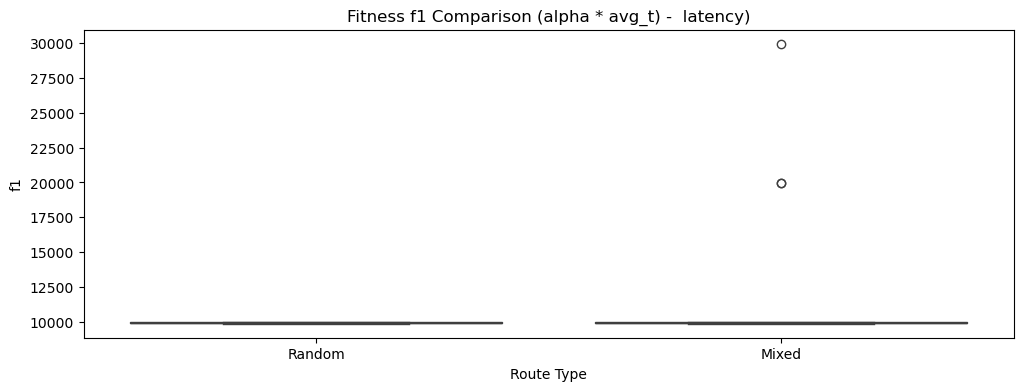

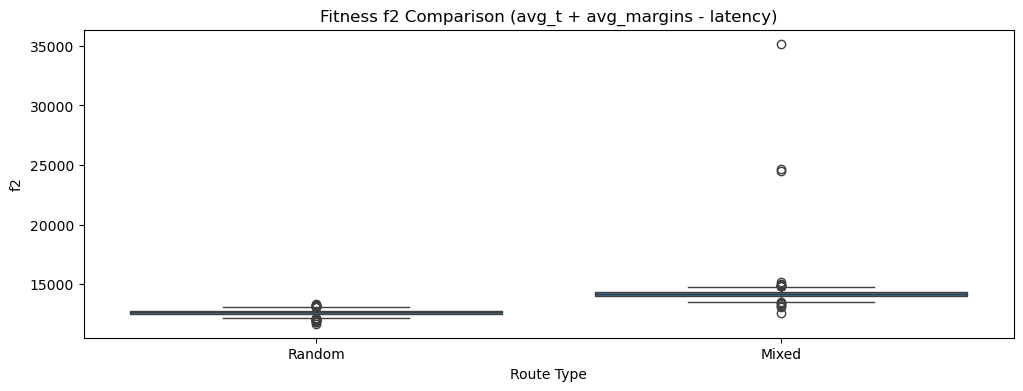

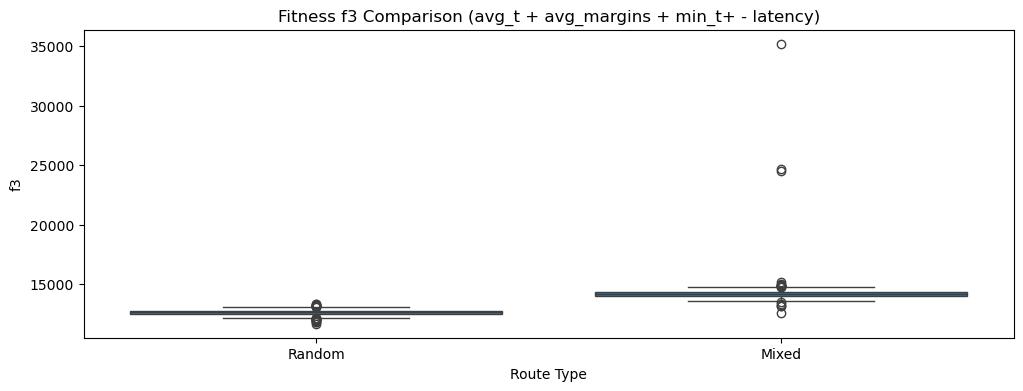

In [101]:

# Visualizing the Fitness Values for each route type
plt.figure(figsize=(12, 4))
sns.boxplot(data=route_df, x="Route Type", y="f1")
plt.title("Fitness f1 Comparison (alpha * avg_t) -  latency)")
plt.show()

plt.figure(figsize=(12, 4))
sns.boxplot(data=route_df, x="Route Type", y="f2")
plt.title("Fitness f2 Comparison (avg_t + avg_margins - latency)")
plt.show()

plt.figure(figsize=(12, 4))
sns.boxplot(data=route_df, x="Route Type", y="f3")
plt.title("Fitness f3 Comparison (avg_t + avg_margins + min_t+ - latency)")
plt.show()

### Observation

When analyzing the fitness functions:

- **Fitness Function 1 (f1)**: The differences between **Mixed Routes** and **Random Routes** appear similar, with minimal disparity. Additionally, the variability within each route type is moderate, as seen in the size of the box plots and their whiskers.  

- **Fitness Function 2 (f2)**: Displays greater disparity between the two route types, providing better differentiation. Within each route type, the average values are more stable, with smaller box sizes and longer whiskers, indicating more concentrated central values but larger extremes.

- **Fitness Function 3 (f3)**: Shows the most significant disparity between the two route types and within each route type itself. The box plots have even smaller boxes and longer spikes, highlighting a tighter average with more pronounced variability at the extremes.


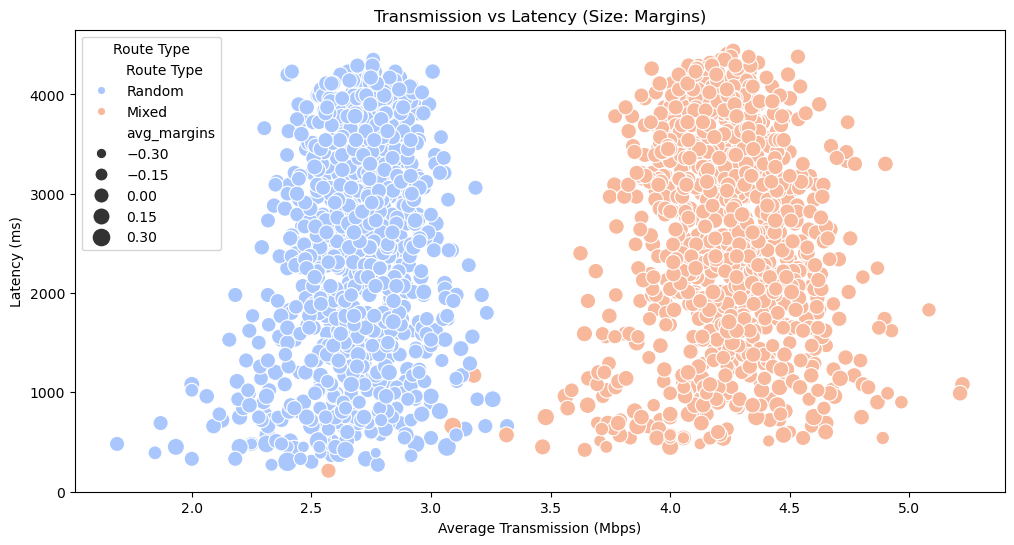

In [102]:
# Trade-offs: Transmission and Margins vs Latency
plt.figure(figsize=(12, 6))
sns.scatterplot(data=route_df, x="avg_t", y="latency", hue="Route Type", size="avg_margins", sizes=(50, 200), palette="coolwarm")
plt.title("Transmission vs Latency (Size: Margins)")
plt.xlabel("Average Transmission (Mbps)")
plt.ylabel("Latency (ms)")
plt.legend(title="Route Type")
plt.show()

### Trade-offs: Transmission and Margins vs Latency

The scatter plot provides the following insights:

- **Mixed Routes** generally produce higher **average transmission rates** compared to **Random Routes**, as evident from their clustering on the higher end of the `avg_t` axis.  
- **Mixed Routes** show a slightly smaller tendency to generate routes with very high **average margin changes** (`avg_margins`) compared to Random Routes. However, the difference is minimal.  
- **High Latency** routes are also less frequent in Mixed Routes, showcasing better performance in maintaining lower latency levels compared to Random Routes.

Overall, Mixed Routes outperform Random Routes by striking a better balance between transmission rates, margins, and latency.


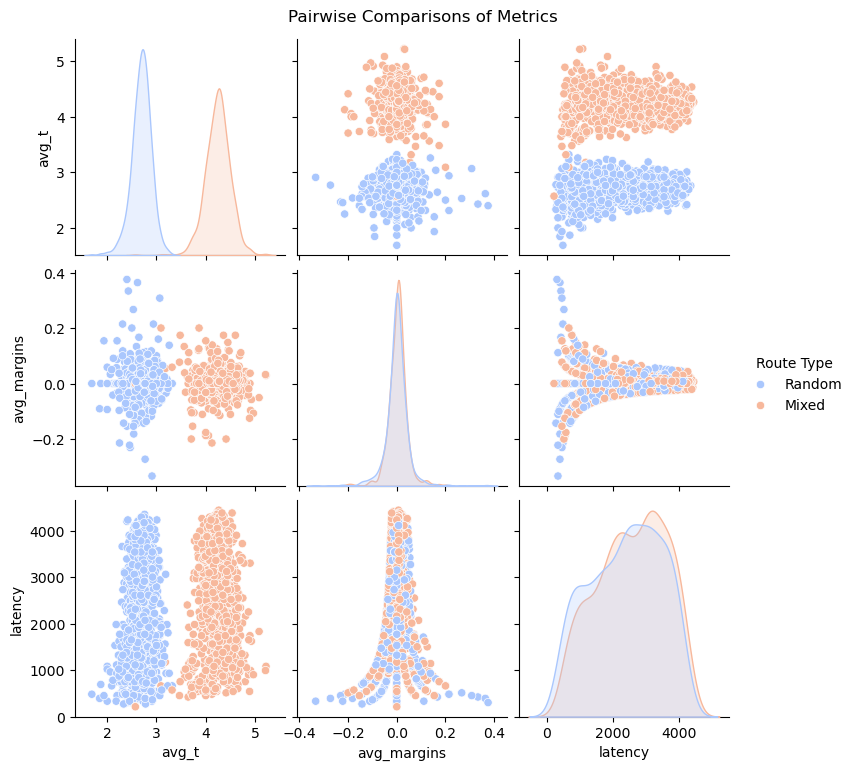

In [103]:
# Pairplot for all key metrics
sns.pairplot(route_df, hue="Route Type", vars=["avg_t", "avg_margins", "latency"], palette="coolwarm", diag_kind="kde")
plt.suptitle("Pairwise Comparisons of Metrics", y=1.02)
plt.show()


In [104]:
# Initialize an empty list to store data
route_data = []
pop_size = 1000

# Generate and analyze routes over 100 iterations
for i in range(pop_size):
    # Generate routes
    mixed_route_gen = mixed_route(start_node, base_stations)

    # Loop through random_route_gen and mixed_route_gen
    for route_type, route_gen in [ ("Mixed", mixed_route_gen)]:
        metrics = get_route_metrics(route_gen)
        # Calculate the fitness for each route
        fitness = calculate_weighted_fitness(route_gen, metrics, latency = len(route_gen), alpha = 1000, beta = 0.1, gamma = 500.0, delta = 100000 )
        route_data.append({
            "Route": route_gen,
            "avg_t": metrics["avg_t"],
            "margins": metrics["margins"],
            "avg_margins": metrics["avg_margins"],
            "min_t": metrics["min_t"],
            "latency": metrics["latency"],
            "f3": fitness["f3"],
        })

# Create DataFrame
mixed_route_df = pd.DataFrame(route_data)

# Display DataFrame
mixed_route_df.sort_values(by='f3', ascending=False)

,Route,avg_t,margins,avg_margins,min_t,latency,f3
172,"[0, 92, 85, 16, 54, 126, 99, 19, 113, 39, 41, ...",5.016949,"[1.0, 3.0, 0.0, 0.0, -3.0, 1.0, 2.0, -2.0, 2.0...",0.035088,1.0,1770,502706.559114
114,"[0, 7, 75, 99, 19, 5, 51, 58, 100, 105, 9, 86,...",4.981132,"[1.0, 0.0, 0.0, -3.0, 3.0, 2.0, 0.0, 0.0, -3.0...",0.000000,1.0,1590,499107.907547
41,"[0, 7, 145, 93, 113, 92, 99, 19, 39, 41, 126, ...",4.969697,"[3.0, -3.0, -1.0, 2.0, -1.0, 1.0, 0.0, 2.0, 0....",0.032258,1.0,990,497982.526002
846,"[0, 7, 145, 93, 149, 5, 134, 114, 34, 84, 44, ...",4.966667,"[3.0, -3.0, 1.0, -1.0, -2.0, 5.0, -2.0, 2.0, -...",-0.034483,1.0,1800,497643.425287
640,"[0, 7, 85, 23, 25, 15, 33, 106, 101, 138, 18, ...",4.901639,"[-3.0, 0.0, 3.0, 3.0, 0.0, -2.0, 2.0, -6.0, 4....",-0.033898,1.0,1830,491140.885274
...,...,...,...,...,...,...,...
856,"[0, 7, 85, 53, 32, 59, 4, 21, 100, 51, 58, 106...",3.263158,"[-3.0, 1.0, 0.0, -1.0, 4.0, -4.0, 0.0, 6.0, 0....",0.058824,1.0,570,327343.301238
611,"[0, 19, 132, 119, 73, 60, 83, 56, 48, 27, 84, ...",3.200000,"[-2.0, 0.0, 4.0, -4.0, 6.0, -6.0, 0.0, 4.0, -3...",0.071429,1.0,900,321032.714286
250,"[0, 19, 93, 149, 35, 36, 42, 40, 71, 14, 150]",3.181818,"[0.0, 2.0, -4.0, 4.0, -4.0, 6.0, -5.0, 3.0, -2.0]",0.000000,1.0,330,319180.718182
469,"[0, 7, 149, 75, 99, 113, 20, 8, 22, 2, 151]",3.181818,"[-1.0, 1.0, 1.0, 0.0, -3.0, 0.0, 2.0, 1.0, -4.0]",-0.333333,1.0,330,319014.051515


# Selection

### **Final Selection Method for Balancing Transmission, Margins, and Latency**

Given the context of balancing **transmission, margins, and latency**, our final selection method is a **hybrid** approach designed to balance **exploration** and **exploitation** while preserving the best solutions and maintaining diversity across generations.

#### **Primary Selection Method**:
We will use a **Hybrid Selection Method** that combines:
- **Top n% Selection**: Select the top **n%** of the population based on fitness, ensuring the best solutions are prioritized.
- **Random Selection**: A small portion of the population will be selected randomly to maintain diversity and prevent premature convergence.
- **Elitism**: A small portion of the best individuals (e.g., top 1-2%) will always be preserved and passed to the next generation, ensuring high-quality solutions are never lost.


---


In [105]:
def hybrid_selection(df, fitness_column, top_percentage=20, random_percentage=10, elitism_percentage=5):
    """
    Perform hybrid selection combining Top n% selection, random selection, and elitism.

    Parameters:
        df (pd.DataFrame): The dataframe containing routes and their fitness scores.
        fitness_column (str): The column name representing fitness values.
        top_percentage (float): The percentage of the top individuals to select based on fitness (e.g., 20).
        random_percentage (float): The percentage of the population to select randomly (e.g., 10).
        elitism_percentage (float): The percentage of the best individuals to always retain (e.g., 5).

    Returns:
        pd.DataFrame: The selected individuals.
    """
    # Ensure all columns are hashable (e.g., convert lists to tuples or strings if needed)
    for column in df.columns:
        if df[column].apply(lambda x: isinstance(x, list)).any():
            df[column] = df[column].apply(lambda x: tuple(x) if isinstance(x, list) else x)

    # Sort individuals by fitness (descending order)
    sorted_df = df.sort_values(by=fitness_column, ascending=False)

    # Number of individuals to select
    total_population = len(df)

    # Elitism: Always keep the top elitism_percentage individuals
    elitism_count = int(total_population * (elitism_percentage / 100))
    elitism_individuals = sorted_df.head(elitism_count)

    # Top n% selection: Select the top 'top_percentage' individuals based on fitness
    top_n_count = int(total_population * (top_percentage / 100))
    top_individuals = sorted_df.head(top_n_count)

    # Random selection: Select individuals randomly
    random_count = int(total_population * (random_percentage / 100))
    random_individuals = df.sample(n=random_count)

    # Combine all selected individuals
    selected_individuals = pd.concat([elitism_individuals, top_individuals, random_individuals]).drop_duplicates()

    # Ensure we don't exceed the original population size
    if len(selected_individuals) > total_population:
        selected_individuals = selected_individuals.head(total_population)

    return selected_individuals.sort_values(by='f3', ascending=False)

# Example Usage
selected_individuals = hybrid_selection(mixed_route_df, fitness_column="f3", top_percentage=20, random_percentage=10, elitism_percentage=5)

# Crossover Process Summary

1. **Parent Selection**:
   - We will select two parents from the `selected_individuals` based on the **Hybrid Selection Method**. They do not have to be the best routes. They need to have similar node points in order to swap corresponding nodes.

2. **Crossover Logic**:
   - For each parent, we will identify common nodes (segments) in their routes.
   - Then perform **One-Point Crossover** by swapping the suffix of the parent routes at the common node.
   - Example: If a common node `58` exists for both routes, swap the remaining segments of the routes after node `58`.

3. **Route Validation**:
   - No need to validate the routes, since we found a common node they shared. We can only check if that route already exist in our `selected individuals`

4. **Route Metrics Calculation**:
   - After crossover, calculate the metrics for the new routes (transmission, margins, latency).
   - Compute the fitness (`f3`) for the new children based on the updated metrics.



In [106]:
def find_common_node(route1, route2):
    """
    Find the first common node between two routes.
    Returns the index of the common node in each route.
    """
    common_node = None
    for i, node1 in enumerate(route1):
        if node1 in route2:
            common_node = node1
            idx2 = route2.index(common_node)
            return i, idx2  # return indices of common node in both routes
    return None, None  # no common node

def crossover_with_common_node(parent1, parent2):
    """
    Perform crossover by finding a common node and swapping the segments after it.
    """
    # Find the common node and its index in both parents
    idx1, idx2 = find_common_node(parent1, parent2)

    if idx1 is None or idx2 is None:
        # No common node, so no valid crossover can be performed
        return parent1, parent2

    # Create new routes by swapping the segments after the common node
    child1 = parent1[:idx1+1] + parent2[idx2+1:]
    child2 = parent2[:idx2+1] + parent1[idx1+1:]

    return child1, child2

# Example usage
parent1_route = [75, 7, 145, 135, 133, 114, 58, 5, 67, 143, 38]
parent2_route = [75, 7, 145, 93, 5, 51, 58, 100, 105, 54, 16]

# Perform crossover based on common node
child1, child2 = crossover_with_common_node(parent1_route, parent2_route)

print("Parent 1:", parent1_route)
print("Parent 2:", parent2_route)
print("Child 1:", child1)
print("Child 2:", child2)


Parent 1: [75, 7, 145, 135, 133, 114, 58, 5, 67, 143, 38]
Parent 2: [75, 7, 145, 93, 5, 51, 58, 100, 105, 54, 16]
Child 1: [75, 7, 145, 93, 5, 51, 58, 100, 105, 54, 16]
Child 2: [75, 7, 145, 135, 133, 114, 58, 5, 67, 143, 38]


In [107]:
def convert_children_to_df():
    """
    Converts the list of children data into a DataFrame, ensuring no duplicate routes.

    Parameters:
    - children_data: A list of dictionaries containing the children routes and their metrics.

    Returns:
    - children_df: The DataFrame containing the routes without duplicates.
    """
    children_df = pd.DataFrame(children_data)
    children_df = children_df.drop_duplicates(subset='Route', keep='first')
    return children_df.sort_values(by='f3', ascending=False)

In [108]:
children_data = []

def generate_children(selected_individuals):

    """
    Generates children from selected individuals with crossover and mutation.

    Parameters:
    - selected_individuals: DataFrame of selected individuals for crossover
    - transmission_rate_matrix: The transmission rate matrix to compute metrics
    - base_stations: List of valid base stations
    - children_data: The list storing all children data across generations
    - mutation_rate: The probability of mutation

    Returns:
    - children_data: Updated list of children data
    """

    # Generate children
    for i in range(0, len(selected_individuals)-1, 2):  # Pairing parents
        # Use iloc for safe integer-based indexing of DataFrame rows
        parent1 = selected_individuals.iloc[i]
        parent2 = selected_individuals.iloc[i+1]

        # Perform crossover
        child1, child2 = crossover_with_common_node(parent1['Route'], parent2['Route'])

        # Get metrics for both children
        child1_metrics = get_route_metrics(child1)
        child2_metrics = get_route_metrics(child2)

        # Calculate fitness for both children
        child1_fitness = calculate_weighted_fitness(child1, child1_metrics, latency=len(child1))
        child2_fitness = calculate_weighted_fitness(child2, child2_metrics, latency=len(child2))

        # Add the children to the children data list
        children_data.append({
            "Route": child1,
            "avg_t": child1_metrics["avg_t"],
            "margins": child1_metrics["margins"],
            "avg_margins": child1_metrics["avg_margins"],
            "min_t": child1_metrics["min_t"],
            "latency": child1_metrics["latency"],
            "f3": child1_fitness["f3"],
        })

        children_data.append({
            "Route": child2,
            "avg_t": child2_metrics["avg_t"],
            "margins": child2_metrics["margins"],
            "avg_margins": child2_metrics["avg_margins"],
            "min_t": child2_metrics["min_t"],
            "latency": child2_metrics["latency"],
            "f3": child2_fitness["f3"],
        })

    return convert_children_to_df()



In [109]:
generate_children(selected_individuals)

,Route,avg_t,margins,avg_margins,min_t,latency,f3
175,"(0, 7, 145, 19, 92, 75, 149, 20, 16, 54, 85, 1...",4.461538,"[3.0, -5.0, 5.0, -4.0, 1.0, -2.0, 3.0, 2.0, 0....",0.041667,2.0,780,24456.371795
1,"(0, 92, 85, 16, 54, 126, 99, 19, 113, 39, 41, ...",5.016949,"[1.0, 3.0, 0.0, 0.0, -3.0, 1.0, 2.0, -2.0, 2.0...",0.035088,1.0,1770,14975.493012
3,"(0, 7, 145, 93, 113, 92, 99, 19, 39, 41, 126, ...",4.969697,"[3.0, -3.0, -1.0, 2.0, -1.0, 1.0, 0.0, 2.0, 0....",0.032258,1.0,990,14952.826002
0,"(0, 7, 75, 99, 19, 5, 51, 58, 100, 105, 9, 86,...",4.981132,"[1.0, 0.0, 0.0, -3.0, 3.0, 2.0, 0.0, 0.0, -3.0...",0.000000,1.0,1590,14928.132075
2,"(0, 7, 145, 93, 149, 5, 134, 114, 34, 84, 44, ...",4.966667,"[3.0, -3.0, 1.0, -1.0, -2.0, 5.0, -2.0, 2.0, -...",-0.034483,1.0,1800,14889.425287
...,...,...,...,...,...,...,...
285,"(0, 7, 85, 16, 54, 126, 19, 132, 35, 134, 114,...",3.808511,"[-3.0, 6.0, 0.0, 0.0, -3.0, -3.0, 3.0, -2.0, 5...",-0.066667,1.0,1410,13728.177305
287,"(0, 149, 95, 58, 51, 138, 18, 57, 45, 106, 97,...",3.650000,"[2.0, 0.0, 4.0, -6.0, 4.0, 2.0, -2.0, -3.0, -1...",0.055556,1.0,600,13657.777778
286,"(0, 85, 5, 51, 135, 34, 84, 114, 44, 128, 117,...",3.523810,"[3.0, 1.0, -2.0, 0.0, 4.0, -2.0, -1.0, 1.0, -4...",0.100000,1.0,1260,13531.809524
289,"(0, 113, 20, 149, 34, 63, 58, 94, 139, 26, 57,...",3.500000,"[-2.0, 0.0, -1.0, 3.0, -3.0, 0.0, 1.0, 5.0, -3...",0.055556,1.0,600,13507.777778


# Mutation

We have great routes so far that have good average transmission, min_max end to end transmission and very good latency. Aswell as a good avg_margin rate. We will try mutating routes to see if we can increase fitness values

In [110]:
def mutate_route(route):
    """
    Mutates a route by replacing a node with a shared neighbor of the previous and next node.

    Parameters:
    - route: The list of nodes representing the current route.
    - transmission_rate_matrix: A matrix (or dictionary) that contains the neighbors of each node.

    Returns:
    - mutated_route: The mutated route after applying the mutation.
    """
    # Select a random index to mutate, making sure it's not the first or last node
    if len(route) > 2:
        idx = random.randint(1, len(route) - 2)

        # Previous and next node of the selected index
        prev_node = route[idx - 1]
        next_node = route[idx + 1]

        # Get the neighbors of the previous and next nodes from the transmission matrix
        prev_neighbors = set(np.where(transmission_rate_matrix[prev_node] > 0)[0])
        next_neighbors = set(np.where(transmission_rate_matrix[next_node] > 0)[0])

        # Find common neighbors (intersection of the two sets)
        common_neighbors = list(prev_neighbors.intersection(next_neighbors))

        if common_neighbors:
            # Pick a random common neighbor to replace the current node
            new_node = random.choice(common_neighbors)
            route[idx] = new_node

    return route

def update_child_metrics(route):
    """
    Recalculates the metrics for a given mutated route.

    Parameters:
    - route: The mutated route (list of nodes).
    - transmission_rate_matrix: The matrix that defines transmission characteristics.

    Returns:
    - metrics: A dictionary containing the recalculated metrics for the route.
    """
    # You should replace this with the actual logic for calculating metrics
    metrics = get_route_metrics(route)

    # Calculate fitness based on the new mutated route
    fitness = calculate_weighted_fitness(route, metrics, latency=len(route))

    return {
        "Route": route,
        "avg_t": metrics["avg_t"],
        "margins": metrics["margins"],
        "avg_margins": metrics["avg_margins"],
        "min_t": metrics["min_t"],
        "latency": metrics["latency"],
        "f3": fitness["f3"]
    }


def mutate_random_children(children_df, mutation_rate=0.2):
    """
    Mutates a random subset of children from the children_df and updates the relevant values.

    Parameters:
    - children_df: The DataFrame containing the children and their metrics.
    - transmission_rate_matrix: The matrix that defines the neighbors for mutation.
    - mutation_rate: The fraction of children to mutate (between 0 and 1).

    Returns:
    - updated_children_df: The updated DataFrame with mutated children and recalculated metrics.
    """
    # Get the number of children to mutate based on mutation rate
    num_children_to_mutate = int(len(children_df) * mutation_rate)

    # Randomly select the children to mutate
    selected_children = random.sample(children_df.index.tolist(), num_children_to_mutate)

    updated_children_data = []

    for idx in selected_children:
        # Get the child's route
        child_route = list(children_df.loc[idx, "Route"])

        # Apply mutation to the route
        mutated_route = mutate_route(child_route)

        # Recalculate the metrics for the mutated route
        mutated_child = update_child_metrics(mutated_route)

        # Add the mutated child to the updated children list
        updated_children_data.append(mutated_child)

    # Create DataFrame from mutated children
    updated_children_df = pd.DataFrame(updated_children_data)

    # Merge the mutated children into the original DataFrame, removing duplicates
    updated_children_df = updated_children_df.drop_duplicates(subset='Route', keep='first')

    # Merge with the original DataFrame
    children_df = pd.concat([children_df, updated_children_df], ignore_index=True)

    # Remove any duplicate routes and sort by fitness
    children_df = children_df.drop_duplicates(subset='Route', keep='first')
    children_df = children_df.sort_values(by='f3', ascending=False)

    return children_df

# Example of mutating random children in the children_df:
children_df = convert_children_to_df()
mutated_children_df = mutate_random_children(children_df, mutation_rate=0.2)

# Output the updated children DataFrame with mutated routes and recalculated metrics
mutated_children_df


,Route,avg_t,margins,avg_margins,min_t,latency,f3
0,"(0, 7, 145, 19, 92, 75, 149, 20, 16, 54, 85, 1...",4.461538,"[3.0, -5.0, 5.0, -4.0, 1.0, -2.0, 3.0, 2.0, 0....",0.041667,2.0,780,24456.371795
1,"(0, 92, 85, 16, 54, 126, 99, 19, 113, 39, 41, ...",5.016949,"[1.0, 3.0, 0.0, 0.0, -3.0, 1.0, 2.0, -2.0, 2.0...",0.035088,1.0,1770,14975.493012
2,"(0, 7, 145, 93, 113, 92, 99, 19, 39, 41, 126, ...",4.969697,"[3.0, -3.0, -1.0, 2.0, -1.0, 1.0, 0.0, 2.0, 0....",0.032258,1.0,990,14952.826002
338,"[0, 7, 145, 93, 113, 92, 99, 19, 39, 41, 126, ...",4.969697,"[3.0, -3.0, -1.0, 2.0, -1.0, 1.0, 0.0, 2.0, 0....",0.032258,1.0,990,14952.826002
3,"(0, 7, 75, 99, 19, 5, 51, 58, 100, 105, 9, 86,...",4.981132,"[1.0, 0.0, 0.0, -3.0, 3.0, 2.0, 0.0, 0.0, -3.0...",0.000000,1.0,1590,14928.132075
...,...,...,...,...,...,...,...
286,"(0, 149, 95, 58, 51, 138, 18, 57, 45, 106, 97,...",3.650000,"[2.0, 0.0, 4.0, -6.0, 4.0, 2.0, -2.0, -3.0, -1...",0.055556,1.0,600,13657.777778
287,"(0, 85, 5, 51, 135, 34, 84, 114, 44, 128, 117,...",3.523810,"[3.0, 1.0, -2.0, 0.0, 4.0, -2.0, -1.0, 1.0, -4...",0.100000,1.0,1260,13531.809524
288,"(0, 113, 20, 149, 34, 63, 58, 94, 139, 26, 57,...",3.500000,"[-2.0, 0.0, -1.0, 3.0, -3.0, 0.0, 1.0, 5.0, -3...",0.055556,1.0,600,13507.777778
320,"[0, 113, 20, 149, 34, 63, 58, 94, 139, 26, 137...",3.350000,"[-2.0, 0.0, -1.0, 3.0, -3.0, 0.0, 1.0, 5.0, -3...",0.055556,1.0,600,13357.777778


# Observations
After running our algorithm several times till to this point we realized mutation has not been effective. However certain routes may benefit from mutation in other iterations. If we want to reduce time complexity we might need to remove mutation from our algorithm since its impact is rare.

Other ways to approach this is to increase the mutation rate.

# Putting it all together
For safety, we decreased the population size to 10 to ensure this algorithm can run as a test 
Slowly increase the population to get more out of our algorithm



The code above run for 16mins  9.8secs on my machine at population size of 1000. 
The code below run for 138mins 46.2seconds at 10,000  

In [111]:
# Initialize an empty dictionary to store data
GAroutes_for_each_node = {}

for start_node in range(len(transmission_rate_matrix)-2):
    route_data = []
    pop_size = 10
    children_data = []

    # Generate and analyze routes over 100 iterations
    for i in range(pop_size):
        # Generate routes
        mixed_route_gen = mixed_route(start_node, base_stations)

        # Loop through mixed_route_gen
        for route_gen in [mixed_route_gen]:
            metrics = get_route_metrics(route_gen)
            # Calculate the fitness for each route
            fitness = calculate_weighted_fitness(route_gen, metrics, latency=len(route_gen), 
                                                 alpha=10000, beta=1, gamma=500.0, delta=1000)
            route_data.append({
                "Route": route_gen,
                "avg_t": metrics["avg_t"],
                "margins": metrics["margins"],
                "avg_margins": metrics["avg_margins"],
                "min_t": metrics["min_t"],
                "latency": metrics["latency"],
                "f3": fitness["f3"],
            })

    # Create DataFrame
    route_df = pd.DataFrame(route_data)
    selected_individuals = hybrid_selection(route_df, fitness_column="f3", top_percentage=20, random_percentage=10, elitism_percentage=5)
    children_df = generate_children(selected_individuals)
    mutated_children_df = mutate_random_children(children_df, mutation_rate=0.2)

    # Get the first route and its metrics from the mutated children
    route = mutated_children_df["Route"].iloc[0]
    min_t = mutated_children_df["min_t"].iloc[0]

    # Convert route into the desired JSON format
    routing_path = []
    for i in range(len(route)-1):
        current_node = route[i]
        next_node = route[i+1]
        if next_node == 150:
            routing_path.append(("BS-1", f"{transmission_rate_matrix[current_node][next_node]}Mbps"))
        elif next_node == 151:
            routing_path.append(("BS-2", f"{transmission_rate_matrix[current_node][next_node]}Mbps"))
        else:
            routing_path.append((f"Node-{next_node}", f"{transmission_rate_matrix[current_node][next_node]}Mbps"))

    # Store data in the required format
    GAroutes_for_each_node[f"Node{start_node}"] = {
        "Source_node": start_node,
        "Routing_path": tuple(routing_path),
        "End_to_end_transmission_rate": f"{min_t}Mbps"
    }

# Save the dictionary to a JSON file
# with open('routes.json', 'w') as json_file:
#     json.dump(GAroutes_for_each_node, json_file, indent=4)

# print("Generated routes saved to routes.json")


# Discussions

We successfully generated optimal routes for each node using our algorithm and were pleased with the overall process. Upon reviewing our approach, we identified several key insights:

- **Future Enhancements:**  
  In future work, we plan to implement all three route generation methods—greedy, mixed, and random—and select the best route from each iteration. This way we can get the best from all three approaches. The down side is it will take longer since we will have to increase the population size to accomodate all three approaches. However the variability in the different routes that will be generated ensure we find optimal routes.

- **Node Information Management:**  
  We discussed strategies to maintain inter-node information, such as iterating through nodes based on proximity. The idea is we will group nodes that are close to each other. Once a highly efficient route is identified based on a fitness criteria by a node, we intend to prioritize nearby nodes to route through this optimal path while others continue to determine their own best paths independently. Computationally we will just need to find the best route for one node and then use that for the rest of the nodes in proximity.

These reflections highlight the strengths of our current methodology and outline potential improvements to enhance route optimization in future


## ANT COLONY ALGORITHM
![methodology_aco.jpg](./methodology_aco.jpg)


The Ant Colony algorithm excels at solving routing problems by efficiently finding the shortest path to a goal. It utilizes pheromones to iteratively validate and strengthen these paths.

## **Methodology**
Our approach is straightforward: a population of ants will be `deployed`, each starting at a specific node and navigating toward a base station. As ants traverse different paths, their routes are recorded and the pheromone levels on those paths are updated. Nodes and paths that are traversed more frequently accumulate higher pheromone levels, reinforcing their likelihood of being chosen in subsequent iterations. Meanwhile, pheromone evaporation ensures that less optimal paths gradually lose influence.

To evaluate and compare routes, we useour fitness function similar to the one in our modified Genetic Algorithm. This allows us to select and refine the best paths over successive iterations. The more ants we deploy, the greater the diversity of potential routes explored, increasing the chances of discovering optimal solutions.

Key parameters in our implementation include:

rho: Pheromone deposit rate, determining how much pheromone is added to paths after being traversed by an ant.
evaporation_rate: The rate at which pheromones evaporate, preventing stagnation on suboptimal paths.
alpha: The relative importance of pheromone levels in influencing path selection.
beta: The relative importance of distance(transmission) in influencing path selection.


![Ant colony.png](./Ant%20colony.png)

- Fig 2. Experimental setup for the double bridge experiment. Branches have equal lengths. Branches have different lengths [6]
- Source: M. Dorigo et al 2006 "Ant colony optimization"

In [112]:
# Initialize the pheromone matrix with a small value
pheromone_matrix = np.ones_like(distance_matrix) * 0.1  # Use np.ones_like to create a matrix of 1s with the same shape as distance_matrix
pheromone_matrix

array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

In [113]:
base_stations=[150, 151]
# Example Parameters (tweak as needed)
num_ants = 50      
alpha = 1.0       
beta = 2.0       
rho = 0.5          
max_iterations = 5
evaporation_interval = 5  

### Search Ants
Our search ants represents our routes. Every ant has a unqiue route. Once the ants start using similar routes we deemed that route as the best.

In [114]:
def search_ants(current_node, visited, transmission_rate_matrix, pheromone_matrix, rho=0.1, alpha=1.0, beta=2.0):
    """
    Select the next node based on a probabilistic approach that considers
    pheromone levels and transmission rates. Prioritizes nodes closer to base stations.

    Parameters:
    - current_node: Current node of the ant.
    - visited: Set of nodes already visited by the ant.
    - transmission_rate_matrix: Matrix representing transmission rates between nodes.
    - pheromone_matrix: Matrix representing pheromone levels between nodes.
    - rho: Pheromone deposit factor.
    - alpha: Importance of pheromone level in the decision.
    - beta: Importance of heuristic information (inverse distance) in the decision.

    Returns:
    - next_node: The next node to move to, or None if no valid node is found.
    """
    available_nodes = [
        node for node in range(len(transmission_rate_matrix))
        if node not in visited and transmission_rate_matrix[current_node, node] > 0
    ]

    if not available_nodes:
        return None  # No valid next nodes

    # Calculate probabilities for available nodes
    probabilities = []
    for next_node in available_nodes:
        pheromone = pheromone_matrix[current_node, next_node] ** alpha
        transmission_rate = transmission_rate_matrix[current_node, next_node] ** beta

        # Clamp excessively large or small values to avoid overflow/underflow
        pheromone = np.clip(pheromone, 1e-10, 1e10)
        transmission_rate = np.clip(transmission_rate, 1e-10, 1e10)

        # Combine pheromone and heuristic information
        probabilities.append(pheromone * transmission_rate)

    # Safely normalize probabilities
    total_prob = sum(probabilities)
    if total_prob > 0 and np.isfinite(total_prob):
        probabilities = [prob / total_prob for prob in probabilities]
    else:
        # If total_prob is zero or NaN, use uniform probabilities
        probabilities = [1 / len(available_nodes)] * len(available_nodes)

    # Select the next node based on the probabilities
    next_node = random.choices(available_nodes, weights=probabilities, k=1)[0]

    # Update pheromone level for the edge between current_node and next_node
    pheromone_matrix[current_node, next_node] += rho
    pheromone_matrix[next_node, current_node] += rho  # Assuming undirected graph

    return next_node


In [115]:
def deposit_pheromones(pheromone_matrix, routes, route_costs):
    for route, cost in zip(routes, route_costs):
        pheromone_deposit = 1.0 / cost if cost > 0 else 0.0
        for i in range(len(route) - 1):
            a = route[i]
            b = route[i + 1]
            pheromone_matrix[a, b] += pheromone_deposit
            pheromone_matrix[b, a] += pheromone_deposit

In [116]:
def evaporate_pheromones(pheromone_matrix, rho):
    pheromone_matrix *= (1 - rho)

In [117]:
def construct_solution_and_print(start_node, transmission_rate_matrix = transmission_rate_matrix, pheromone_matrix = pheromone_matrix, rho=rho, evaporation_interval=5):
    """
    Construct a single ant's route starting from 'start_node'.
    The ant moves towards a base station (150 or 151).
    Evaporates pheromones every 'evaporation_interval' moves.
    Returns None if a valid route cannot be constructed.
    """
    route = [start_node]
    current_node = start_node
    visited = set(route)
    move_count = 0


    while current_node not in base_stations:
        next_node = search_ants(current_node, visited, transmission_rate_matrix, pheromone_matrix)
        if next_node is None:
            # Route is invalid
            return None
        route.append(next_node)
        visited.add(next_node)
        current_node = next_node
        move_count = move_count +1

        # Immediate pheromone update already handled in select_next_node

        # Check if move_count is divisible by evaporation_interval
        if move_count % evaporation_interval == 0:
          print(pheromone_matrix[route[-2]][route[-1]])
          evaporate_pheromones(pheromone_matrix, rho)
          print(pheromone_matrix[route[-2]][route[-1]])
    print(move_count)
    move_count = 0
    return route


The code above shows our initial idea for generating routes.
For both Algorithms the way we generate routes has been a crucial stepping stone to proceed with our methodology. It determines how we continue with our laid out plan.

## **Challenges Encountered**
While testing our route generation method, we noticed a significant issue: the routes generated were often excessively long. Unlike the Genetic Algorithm, where invalid routes were a primary concern, the Ant Colony algorithm successfully generated valid paths. However, these paths were often suboptimal due to their length. As we know, longer routes inherently lead to higher latency, which undermines the algorithm's efficiency.

## **Solution: Limiting Maximum Hops**
To address this issue, we introduced a maximum hop count constraint. By setting a cap on the number of hops an ant can take to reach its destination, we were able to discard overly long routes, even if they were otherwise valid. This adjustment ensures that the algorithm prioritizes shorter, more efficient paths, helping us minimize latency and improve overall performance.

This refinement builds on our foundational approach, striking a balance between generating diverse routes and maintaining the efficiency of the solutions.

In [118]:
def construct_solution(start_node, transmission_rate_matrix=transmission_rate_matrix, pheromone_matrix=pheromone_matrix, rho=rho, evaporation_interval=10, max_hops=100):
    """
    Construct a single ant's route starting from 'start_node'.
    The ant moves towards a base station (150 or 151).
    Evaporates pheromones every 'evaporation_interval' moves.
    Limits the route to 'max_hops' to avoid excessively long routes.
    """
    route = [start_node]
    current_node = start_node
    visited = set(route)
    move_count = 0

    while current_node not in base_stations:
        # Enforce max hops
        if move_count >= max_hops:
            return None  # Route invalid due to excessive hops

        # Select the next node with enhanced probability criteria
        next_node = search_ants(current_node, visited, transmission_rate_matrix, pheromone_matrix)
        if next_node is None:
            return None  # Route invalid due to no valid next node

        route.append(next_node)
        visited.add(next_node)
        current_node = next_node
        move_count += 1

        # Immediate pheromone update already handled in search_ants

        # Evaporate pheromones periodically
        if move_count % evaporation_interval == 0:
            evaporate_pheromones(pheromone_matrix, rho)

    return route

In [119]:
#print(construct_solution(0))

Run the above code a couple times and notice some have `None` values. These are routes that exceed the max hop limit.

In [120]:
def run_aco_test(start_node, base_stations, transmission_rate_matrix, pheromone_matrix, num_ants, alpha, beta, rho, max_iterations, evaporation_interval=5):
    best_route = None
    best_fitness = float('-inf')  # Initialize to -inf for maximizing fitness
    best_metrics = None
    invalid_routes_count = 0

    initial_pheromone_matrix = pheromone_matrix.copy()  # Save the initial state for resetting

    for iteration in range(max_iterations):
        # Reset pheromone matrix for each iteration
        pheromone_matrix = initial_pheromone_matrix.copy()

        routes = []
        route_fitnesses = []  # Store fitness instead of costs

        for ant in range(num_ants):
            # Construct a solution for the current ant
            route = construct_solution(start_node, transmission_rate_matrix, pheromone_matrix, evaporation_interval)
            if route is None:
                invalid_routes_count += 1
                continue

            # Calculate metrics and fitness for the route
            metric = get_route_metrics(route)
            fitness = calculate_weighted_fitness(route, metric, len(route), alpha=1000, beta=1, gamma=500, delta=10000)
            f3 = fitness["f3"]  # Use f3 as the fitness value

            routes.append(route)
            route_fitnesses.append(f3)

        if not routes:
            print(f"Iteration {iteration + 1}/{max_iterations}: No valid routes found.")
            continue

        # Update global best route and fitness
        iteration_best_index = np.argmax(route_fitnesses)  # Use argmax for highest fitness
        if route_fitnesses[iteration_best_index] > best_fitness:
            best_fitness = route_fitnesses[iteration_best_index]
            best_route = routes[iteration_best_index]
            best_metrics = get_route_metrics(best_route)  # Recalculate metrics for the best route

        # Update pheromone matrix based on routes and fitnesses
        for route, fitness in zip(routes, route_fitnesses):
            pheromone_contribution = fitness  # Higher fitness deposits more pheromone
            for i in range(len(route) - 1):
                pheromone_matrix[route[i], route[i+1]] += pheromone_contribution

        if (iteration + 1) % evaporation_interval == 0:
            pheromone_matrix *= (1 - rho)  # Evaporate pheromones
            pheromone_matrix = np.clip(pheromone_matrix, 1e-10, 1e10)  # Clamp pheromone values to prevent NaN

        print(f"Iteration {iteration + 1}/{max_iterations}: Best fitness so far = {best_fitness}")

    print(f"\nTotal invalid routes encountered: {invalid_routes_count}")

    return best_route, best_fitness, best_metrics


# Putting it Together

In [121]:
start_node = 0
base_stations = [150, 151]

# Run the ACO algorithm
final_route, final_cost, final_metrics = run_aco_test(
    start_node=start_node,
    base_stations=base_stations,
    transmission_rate_matrix=transmission_rate_matrix,
    pheromone_matrix=pheromone_matrix,
    num_ants=num_ants,
    alpha=alpha,
    beta=beta,
    rho=rho,
    max_iterations=max_iterations,
    evaporation_interval=evaporation_interval
)


if final_route is not None:
    print("\nBest route found:")
    best_route_nodes = final_route  # Placeholder
    print(" -> ".join(map(str, best_route_nodes)))
    print(f"Cost of the best route: {final_cost}")
    print("Metrics of the best route:")
    for key, value in final_metrics.items():
        print(f"{key}: {value}")
else:
    print("No valid route was found.")

Iteration 1/5: Best fitness so far = 47794.917686318135
Iteration 2/5: Best fitness so far = 47794.917686318135
Iteration 3/5: Best fitness so far = 47794.917686318135
Iteration 4/5: Best fitness so far = 47794.917686318135
Iteration 5/5: Best fitness so far = 49030.03703703703

Total invalid routes encountered: 103

Best route found:
0 -> 75 -> 19 -> 7 -> 149 -> 99 -> 41 -> 85 -> 16 -> 54 -> 51 -> 100 -> 147 -> 23 -> 121 -> 129 -> 101 -> 106 -> 25 -> 15 -> 21 -> 107 -> 124 -> 55 -> 50 -> 98 -> 151
Cost of the best route: 49030.03703703703
Metrics of the best route:
avg_t: 4.703703703703703
margins: [np.float64(0.0), np.float64(-1.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(0.0), np.float64(-5.0), np.float64(5.0), np.float64(-4.0), np.float64(0.0), np.float64(1.0), np.float64(3.0), np.float64(-2.0), np.float64(2.0), np.float64(0.0), np.float64(0.0), np.float64(-2.0), np.float64(-3.0), np.float64(5.0), np.float64(-2.0), np.float64(

In [122]:
def run_aco(start_node, base_stations, transmission_rate_matrix, pheromone_matrix, num_ants, alpha, beta, rho, max_iterations=50, evaporation_interval=5):
    routes = []
    fitness_scores = []
    pheromone_matrix_copy = pheromone_matrix.copy()
    invalid_routes_count = 0
    best_route = None
    best_metrics = None
    best_fitness = -float('inf')  # Global best across all iterations

    for iteration in range(max_iterations):
        iteration_routes = []
        iteration_fitness_scores = []

        for ant in range(num_ants):
            # Construct a solution for the current ant
            route = construct_solution(start_node, transmission_rate_matrix, pheromone_matrix, evaporation_interval)
            if route is None:
                invalid_routes_count += 1
                continue

            # Calculate metrics and fitness for the route
            metric = get_route_metrics(route)
            fitness = calculate_weighted_fitness(route, metric, len(route), alpha=1000, beta=1, gamma=500, delta=10000)
            fitness_score = fitness["f3"]  # Focus only on fitness f3

            iteration_routes.append(route)
            iteration_fitness_scores.append(fitness_score)

            # Update global best based on the highest fitness
            if fitness_score > best_fitness:
                best_fitness = fitness_score
                best_route = route
                best_metrics = metric  # Save metrics for the best route

        # Update pheromone matrix based on current iteration's routes
        deposit_pheromones(pheromone_matrix, iteration_routes, iteration_fitness_scores)

    return best_route, best_metrics, best_fitness

In [ ]:
ACOroutes_for_each_node = {}
for start_node in range(len(transmission_rate_matrix)-2):  # Loop through all nodes
    print(f"Running ACO for start node: {start_node}")

    # Run the ACO algorithm for the current start node
    final_route, final_metrics, fitness = run_aco(
        start_node=start_node,
        base_stations=base_stations,
        transmission_rate_matrix=transmission_rate_matrix,
        pheromone_matrix=pheromone_matrix.copy(),  # Use a copy to avoid contamination
        num_ants=10,
        alpha=alpha,
        beta=beta,
        rho=rho,
        max_iterations=1,
        evaporation_interval=evaporation_interval
    )

    if final_route is not None:
        routing_path = []
        for i in range(len(final_route) - 1):
            current_node = final_route[i]
            next_node = final_route[i + 1]
            if next_node == 150:
                routing_path.append(("BS-1", f"{transmission_rate_matrix[current_node][next_node]}Mbps"))
            elif next_node == 151:
                routing_path.append(("BS-2", f"{transmission_rate_matrix[current_node][next_node]}Mbps"))
            else:
                routing_path.append((f"Node{next_node}", f"{transmission_rate_matrix[current_node][next_node]}Mbps"))

        # Store the results for this node
        ACOroutes_for_each_node[f"Node{start_node}"] = {
            "source_node": start_node,
            "routing_path": tuple(routing_path),
            "end_to_end_transmission_rate": f"{final_metrics["min_t"]}Mbps"
        }

# Save the ACO results to a JSON file
# with open('ants_routes.json', 'w') as json_file:
#     json.dump(ACOroutes_for_each_node, json_file, indent=4)

# print("Ant Colony Optimization routes saved to ants_routes.json")

When comparing Genetic Algorithms (GA) and Ant Colony Optimization (ACO), they both shine in their own way for routing problems but differ significantly in their approach and behavior. Here's a breakdown of some key aspects in a table, followed by a deeper discussion:

---

### Key Differences

| Aspect                    | Genetic Algorithm (GA)                                                                                           | Ant Colony Optimization (ACO)                                                             |
|---------------------------|-----------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| **Core Idea**             | Evolving a population of solutions using principles like selection, mutation, and crossover.                    | Simulating ant behavior with pheromone trails to probabilistically find and reinforce routes. |
| **Route Validation**      | Thanks to its greedy nature it efficiently identifies optimal paths within generated neighbors                  | May explore invalid paths, especially when max hop is very high.                              |
| **Execution Time**        | Takes longer but ensures thorough exploration of the solution space, producing solid results.                   | Can be faster but may waste time on invalid routes unless max hop is constrained.        |
| **Best at**               | Finding diverse, high-quality solutions across complex search spaces.                                           | Rapidly zeroing in on the shortest paths in dynamic environments.                        |

---

### Observations and Insights

1. **Greedy but Effective GA**  
    Our modified Genetic Algorithm integrates Dijkstra, so all routes it evaluates are valid from the start. This "greedy" aspect ensures that no time is wasted on invalid paths, allowing the algorithm to focus on refining the best ones. The trade-off is that GA tends to run longer because it thoroughly explores the solution space. Also even when we generated random nodes, it was in a specific search space. hence all possible neighbors are considered

2. **ACO’s Exploratory Nature**  
   Ant Colony Optimization, on the other hand, iteratively learns which paths are best. If the max hop is set too high (like 100 in our setup), ants spend little time on invalid routes however the routes it generates are suboptimal routes. Reducing the max hop drastically improves results but limits the solution space explored. It’s a delicate balance between exploring enough and wasting time.

3. **Speed vs. Quality**  
   GA might take longer but is like an artist carefully perfecting their work—each generation brings better results. ACO, in contrast, is like a group of scouts quickly mapping out the terrain and homing in on the shortest route. However, the scouts can occasionally wander off-course without proper constraints.

4. **Parameter Sensitivity**  
   GA demands fine-tuning of population size, mutation rate, and crossover strategy. With ACO, tweaking pheromone evaporation rates and max hop has a significant impact on its performance. Both require some trial and error to perform optimally.

5. **Practical Tip**  
   You noticed that by tweaking the max hop for ACO, you could drastically improve its routes. Meanwhile, GA already has a solid baseline thanks to Dijkstra, meaning less tweaking is needed to guarantee valid paths. This makes GA more robust for guaranteed quality but less dynamic than ACO.

---

In conclusion, both algorithms are effective in solving our objective. The choice in which is better is a matter of preference and computational requirements.


# References


[1] Argonaut, 2025. *Argonaut* [online]. YouTube. Available from: [https://www.youtube.com/channel/UCFIabE5n4mQgQvd97FAgjhg](https://www.youtube.com/channel/UCFIabE5n4mQgQvd97FAgjhg) [Accessed 1 Jan 2025].

[2] *Bournemouth Uni.* (2024). *Brightspace*. Retrieved from [https://bournemouth.ac.uk/d21/le/lessons/lessons/447727/topics/2132761](https://bournemouth.ac.uk/d21/le/lessons/lessons/447727/topics/2132761)

[3] *Bournemouth Uni.* (2024). Lecture slide **Search & Optimisation: Optimal Routing Path**. *Brightspace*. Retrieved from [https://bournemouth.ac.uk](https://bournemouth.ac.uk)

[4] *Bournemouth Uni.* (2024). Lecture slide **Search & Optimisation: Sub_data_file with_header**. *Brightspace*. Retrieved from [https://bournemouth.ac.uk](https://bournemouth.ac.uk)

[5] Cutajar, J., 2025. *James Cutajar* [online]. YouTube. Available from: [https://www.youtube.com/channel/UCEjnyZLCK-y4D8xuPR0S2mg](https://www.youtube.com/channel/UCEjnyZLCK-y4D8xuPR0S2mg) [Accessed 3 Jan 2025].

[6] Dorigo, M., Birattari, M., and Stutzle, T., 2006. *Ant colony optimization.* *IEEE Computational Intelligence Magazine* [online], 1 (4), 28–39. Available from: [https://ieeexplore.ieee.org/document/4129846](https://ieeexplore.ieee.org/document/4129846) [Accessed 4 Jan 2025].

[7] Katoch, S., Chauhan, S. S., and Kumar, V., 2020. *A review on genetic algorithm: past, present, and future.* *Multimedia Tools and Applications*, 80 (5).

[8] Yassine, H. M., and Zahira, C., 2020. *An Improved Optimization Algorithm to Find Multiple Shortest Paths over Large Graph.* 2020 *Second International Conference on Embedded & Distributed Systems (EDiS)* [online], 178–182. Available from: [https://ieeexplore.ieee.org/abstract/document/9296433?casa_token=cyxJlTPqX58AAAAA:4k5wvWgg4xJIGRNYyax7uSa4hVrjOfONdqqnop4c2ipC7JYIZjc_LZ6I0xcJnIBVMoiDHH8vAQ](https://ieeexplore.ieee.org/abstract/document/9296433?casa_token=cyxJlTPqX58AAAAA:4k5wvWgg4xJIGRNYyax7uSa4hVrjOfONdqqnop4c2ipC7JYIZjc_LZ6I0xcJnIBVMoiDHH8vAQ) [Accessed 2 Jan 2025].
